In [1]:
import xarray as xr
import seaduck as sd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaduck.lagrangian_budget as sdlb
import os

In [3]:
from mattia import densjmd95

In [4]:
sd.__version__

'1.0.1.dev54+g8055b00.d20240328'

In [5]:
import cartopy.crs as ccrs

In [6]:
ds = xr.open_zarr('/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/bgc_tutorial.zarr')
bu = xr.open_zarr('/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/bgc_tutorial_budget.zarr')
ds = xr.merge([ds,bu])

In [7]:
map_path = '/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/map1.zarr'
table_path = '/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/table1.zarr'

In [8]:
zarr_path = '/export/scratch/wjiang33/dic/'

In [9]:
date_identifier = sorted([i[-19:] for i in os.listdir(zarr_path) if 'forward' in i])
ds['index_of_time'] = xr.DataArray(np.arange(len(ds.time)),dims  ='time')
first_index = int(ds['index_of_time'].sel(time = sd.utils.convert_time(date_identifier[0]),method = 'nearest').values)
to_isel = np.arange(first_index, first_index - len(date_identifier),-1)

In [10]:
Rcp = 117
ds['total_bio'] = Rcp*ds['s_p']
ds['negbio'] = -ds['dicbioa']
ds['cdicpflx'] = Rcp*ds['dicpflx']
ds['cdicrdop'] = Rcp*ds['dicrdop']
ds['cnegbio'] = Rcp*ds['negbio']

In [11]:
res = ds['s_p'] - ds['dicpflx']-ds['dicrdop']-ds['negbio']

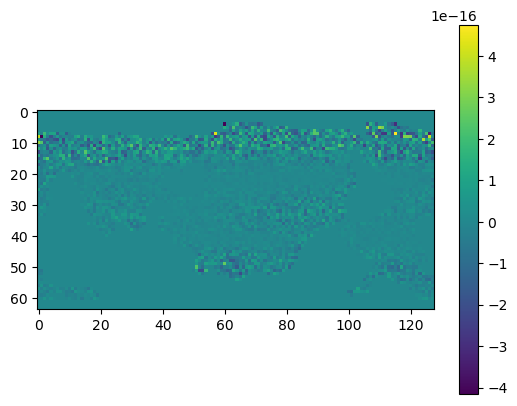

In [12]:
plt.imshow(res[0,0])
plt.colorbar()

In [13]:
# crhs_list = ['e_ua_c','c_dif_h','c_dif_v','diccarb','dictflx','forc_c','total_bio']
crhs_list = ['e_ua_c','c_dif_h','c_dif_v','diccarb','dictflx','forc_c','cdicpflx','cdicrdop','cnegbio']
ctermlist = crhs_list+['tend_c']

In [14]:
# prhs_list = ['e_ua_p','p_dif_h','p_dif_v','s_p','forc_p']
prhs_list = ['e_ua_p','p_dif_h','p_dif_v','dicrdop','dicpflx','forc_p','negbio']
ptermlist = prhs_list+['tend_p']

In [15]:
zarr_fils = sorted([zarr_path+i for i in os.listdir(zarr_path) if 'forward' in i])

In [16]:
ds['utrans'] = ds['UVELMASS']*ds['drF']*ds['dyG']
ds['vtrans'] = ds['VVELMASS']*ds['drF']*ds['dxG']
ds['wtrans'] = ds['WVELMASS']*ds['rA']

In [17]:
tp = sd.Topology(ds)
tub = sd.OceData(ds)

In [18]:
tub._add_missing_vol()

In [19]:
# ind = list(np.array(example[i]) for i in ['iz','iy','ix'])
# ind[0]-=1
# ind = tuple(ind)

# hfac = np.array(ds['HFacC'])[ind]
# vol = np.array(tub['Vol'])[ind]

In [20]:
# rho = densjmd95(ds.S, ds.Temp, 0)-1000
# rhom = rho.mean(dim = 'time_outer').persist()

In [21]:
for i in [0,5,-1]:
    print('checking compatibility: ',i,'...',end = '')
    xrslc = tub._ds.isel(time = 2999)
    example = xr.open_zarr(zarr_fils[2999])
    ans,_ = sdlb.check_particle_data_compat(example,xrslc,tp,wall_names=('cwallx','cwally','cwallz'),conv_name = 'c_res_adv')
    assert ans
    print('pass')
Np = len(example.shapes)

checking compatibility:  0 ...pass
checking compatibility:  5 ...pass
checking compatibility:  -1 ...pass


In [22]:
first,last = sdlb.first_last_neither(np.array(example.shapes),return_neither = False)
ys = np.array(example.yy[last])

In [23]:
high = ys<-45

In [24]:
np.sum(high)

4846

In [25]:
# %%time
# high_first = first[high]
# high_last = last[high]
# high_mask = np.zeros_like(example.nprof)
# for hf,hl in zip(high_first, high_last):
#     high_mask[hf:hl+1] = 1

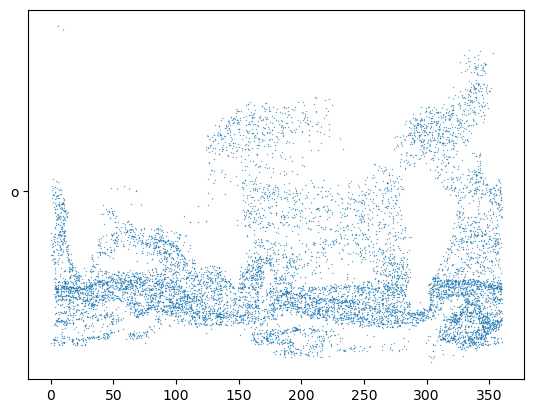

In [26]:
plt.plot(example.xx%360,example.yy,'+','o',markersize = 0.15)

In [27]:
ind = list(np.array(example[i]) for i in ['iz','iy','ix'])
ind[0]-=1
ind = tuple(ind)

hfac = np.array(ds['HFacC'])[ind]

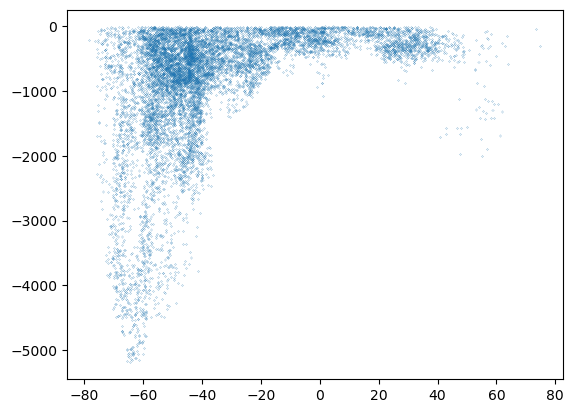

In [28]:
plt.plot(example.yy,example.zz,'o',markersize = 0.1)

In [29]:
# ul,ur = sd.utils._uleftright_from_udu(example.uu,example.du,example.rx)
# vl,vr = sd.utils._uleftright_from_udu(example.vv,example.dv,example.ry)
# wl,wr = sd.utils._uleftright_from_udu(example.ww,example.dw,example.rz-0.5)

In [30]:
# prefetch = [np.array(ds.isel(time = 0)[i]) for i in ['UVELMASS','VVELMASS','WVELMASS']]

In [31]:
# ulist = sdlb.read_wall_list(example,tp, prefetch = prefetch)

In [32]:
# ds['HFacC']

In [33]:
# np.sum(ys<-45)/len(ys)

In [34]:
ind_list = ['iz','iy','ix']

In [35]:
hovmoller = xr.Dataset()
for var in crhs_list+prhs_list+ind_list+['clhs','plhs', 'cf', 'cl','pf','pl', 'lon', 'lat', 'dep','cerror','perror']:
    hovmoller[var] = xr.DataArray(np.zeros((len(date_identifier),Np)),dims = ('time','space'))

In [36]:
maps = {}
for var in crhs_list+prhs_list+['count','cerror','perror']:
    maps[var] = np.zeros((15,64,128))

# maps_high = {}
# for var in crhs_list+prhs_list+['count','cerror','perror']:
#     maps_high[var] = np.zeros((15,64,128))

# maps_low = {}
# for var in crhs_list+prhs_list+['count','cerror','perror']:
#     maps_low[var] = np.zeros((15,64,128))

In [37]:
def cumu_map_zarr(neo, contr_dic, varname, last,mask=1):
    value = contr_dic[varname]
    ind = tuple(np.array(i)[:-1] for i in [neo.iz-1, neo.iy, neo.ix])
    array = np.zeros((15,64,128))
    np.add.at(array, ind, value*mask)
    return array

def cumu_map_array(neo, value,mask = 1):
    ind = tuple(np.array(i)[:-1] for i in [neo.iz-1, neo.iy, neo.ix])
    array = np.zeros((15,64,128))
    np.add.at(array, ind, value*mask)
    return array

In [38]:
import time
t1 = time.time()

In [39]:
for it,(dataset_date, particle_date) in enumerate(zip(to_isel,date_identifier)):
    my = ds.isel(time = dataset_date)
    neo = xr.open_zarr(zarr_fils[it])
    assert particle_date in zarr_fils[it]
    
    ind = tuple(np.array(i) for i in [neo.iz-1,neo.iy,neo.ix])
    ind1 = tuple(neo['ind1'].values)
    ind2 = tuple(neo['ind2'].values)
    frac = np.array(neo.frac)
    shapes = np.array(neo.shapes)
    tres = np.array(neo.tres)
    tact = np.array(neo.tt)
    for prefix in ['c','p']:
        if prefix =='c':
            termlist = ctermlist
            rhs_list = crhs_list
        else:
            termlist = ptermlist
            rhs_list = prhs_list
        prefetch_term = sdlb.prefetch_scalar(my, termlist)
        wall_array = sdlb.prefetch_vector(my,
                                          xname=prefix+"wallx", yname=prefix+"wally", zname=prefix+"wallz",
                                          same_size = False
                                         )
        if it %100==0:
            print('dataset_date:', particle_date, time.time()-t1)
        
        step_dic = sdlb.read_prefetched_scalar(ind,termlist,prefetch_term)
        first, last = sdlb.first_last_neither(shapes,return_neither = False)
        s1 = wall_array[ind1]
        s2 = wall_array[ind2]
        s1[s1==0] = s2[s1==0]
        s2[s2==0] = s1[s2==0]
        
        s_wall = s1*frac + (1-frac)*s2
        assert not np.isnan(s_wall).any()
        nstep = len(frac)-1
        deltas = np.nan_to_num(np.diff(s_wall))
        deltas[last[:-1]] = 0
        tres_used = tres[1:]
        tres_used[last[:-1]] = 0 
        
        correction = sdlb.lhs_contribution(tact, step_dic, last,lhs_name = 'tend_'+prefix)
        rhs_contr = deltas - correction
        
        contr_dic = sdlb.contr_p_relaxed(rhs_contr, tres_used, step_dic, rhs_list,error_prefix = prefix)
        contr_dic[prefix+'lhs'] = correction
        
        for var in rhs_list+[prefix+'lhs',prefix+'error']:
            cumsum = np.cumsum(np.nan_to_num(contr_dic[var]))
            cumsum = np.insert(cumsum[last-1],0,0)
            hovmoller[var][it,:] = np.diff(cumsum)
        
        hovmoller[prefix+'l'][it,:] = s_wall[last]
        hovmoller[prefix+'f'][it,:] = s_wall[first]

        # high_first = first[high]
        # high_last = last[high]
        # high_mask = np.zeros_like(deltas)
        # for hf,hl in zip(high_first, high_last):
        #     high_mask[hf:hl+1] = 1
        # for var in rhs_list+[prefix+'error']:
        #     maps_high[var] += cumu_map_zarr(neo, contr_dic, var, last,high_mask)
        #     maps_low[var] += cumu_map_zarr(neo, contr_dic, var, last,1-high_mask)
        for var in rhs_list+[prefix+'error']:
            maps[var] += cumu_map_zarr(neo, contr_dic, var, last)
    # maps_high['count'] += cumu_map_array(neo, np.ones_like(tres_used),high_mask)
    # maps_low['count'] += cumu_map_array(neo, np.ones_like(tres_used),1-high_mask)
    maps['count']+= cumu_map_array(neo, np.ones_like(tres_used))
    hovmoller['lon'][it,:] = np.array(neo.xx[first])
    hovmoller['lat'][it,:] = np.array(neo.yy[first])
    hovmoller['dep'][it,:] = np.array(neo.zz[first])
    hovmoller['iz'][it,:] = np.array(neo.iz[first])
    # hovmoller['face'][it,:] = np.array(neo.face[first])
    hovmoller['iy'][it,:] = np.array(neo.iy[first])
    hovmoller['ix'][it,:] = np.array(neo.ix[first])

dataset_date: 9066-09-04T12:00:00 1.4981369972229004
dataset_date: 9066-09-04T12:00:00 2.893080234527588
dataset_date: 9068-01-17T12:00:00 98.34422945976257
dataset_date: 9068-01-17T12:00:00 98.70925664901733
dataset_date: 9069-05-31T12:00:00 194.14426708221436
dataset_date: 9069-05-31T12:00:00 194.50486946105957
dataset_date: 9070-10-13T12:00:00 289.7182836532593
dataset_date: 9070-10-13T12:00:00 290.06473207473755
dataset_date: 9072-02-25T12:00:00 385.04208278656006
dataset_date: 9072-02-25T12:00:00 385.4085898399353
dataset_date: 9073-07-09T12:00:00 481.13918805122375
dataset_date: 9073-07-09T12:00:00 481.5132393836975
dataset_date: 9074-11-21T12:00:00 576.3285987377167
dataset_date: 9074-11-21T12:00:00 576.6732170581818
dataset_date: 9076-04-04T12:00:00 671.0913405418396
dataset_date: 9076-04-04T12:00:00 671.4447023868561
dataset_date: 9077-08-17T12:00:00 766.867429971695
dataset_date: 9077-08-17T12:00:00 767.2515561580658
dataset_date: 9078-12-30T12:00:00 862.795975446701
dataset_

In [40]:
np.array(hovmoller['ix'])

array([[  0.,   1.,   2., ..., 127., 127., 127.],
       [  0.,   1.,   2., ..., 127., 127., 127.],
       [  0.,   1.,   2., ..., 127., 127., 127.],
       ...,
       [ 57.,  38.,   1., ...,  16., 127.,  11.],
       [ 57.,  38.,   1., ...,  16., 127.,  11.],
       [ 57.,  38.,   1., ...,  16., 127.,  11.]])

In [41]:
neo

<xarray.Dataset>
Dimensions:  (nprof: 20916, five: 4, shapes: 10196)
Coordinates:
  * five     (five) <U2 'iw' 'iz' 'iy' 'ix'
  * nprof    (nprof) int64 0 1 2 3 4 5 6 ... 20910 20911 20912 20913 20914 20915
  * shapes   (shapes) int64 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
Data variables: (12/21)
    du       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    dv       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    dw       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    frac     (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    ind1     (five, nprof) int16 dask.array<chunksize=(4, 20916), meta=np.ndarray>
    ind2     (five, nprof) int16 dask.array<chunksize=(4, 20916), meta=np.ndarray>
    ...       ...
    vs       (nprof) int16 dask.array<chunksize=(20916,), meta=np.ndarray>
    vv       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    ww       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    xx       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    yy       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>
    zz       (nprof) float64 dask.array<chunksize=(20916,), meta=np.ndarray>

In [42]:
particle_date,zarr_fils[it]

('9107-09-23T00:00:00',
 '/export/scratch/wjiang33/dic/forward9107-09-23T00:00:00')

In [43]:
particle_date,zarr_fils[it]

('9107-09-23T00:00:00',
 '/export/scratch/wjiang33/dic/forward9107-09-23T00:00:00')

In [44]:
maps_ds = xr.Dataset()
for var in maps.keys():
    maps_ds[var] = xr.DataArray(maps[var],dims = ('Z','Y','X'))
    # maps_ds[var+'_high'] = xr.DataArray(maps_high[var],dims = ('Z','Y','X'))
    # maps_ds[var+'_low'] = xr.DataArray(maps_low[var],dims = ('Z','Y','X'))

In [45]:
maps_ds.to_zarr(map_path, mode = 'w')
hovmoller.to_zarr(table_path, mode = 'w')
print('success')

success


In [46]:
maps_ds

<xarray.Dataset>
Dimensions:   (Z: 15, Y: 64, X: 128)
Dimensions without coordinates: Z, Y, X
Data variables: (12/19)
    e_ua_c    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    c_dif_h   (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    c_dif_v   (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    diccarb   (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dictflx   (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    forc_c    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...        ...
    dicpflx   (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    forc_p    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    negbio    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    count     (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cerror    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    perror    (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [47]:
ds.X

<xarray.DataArray 'X' (X: 128)>
array([  1.40625,   4.21875,   7.03125,   9.84375,  12.65625,  15.46875,
        18.28125,  21.09375,  23.90625,  26.71875,  29.53125,  32.34375,
        35.15625,  37.96875,  40.78125,  43.59375,  46.40625,  49.21875,
        52.03125,  54.84375,  57.65625,  60.46875,  63.28125,  66.09375,
        68.90625,  71.71875,  74.53125,  77.34375,  80.15625,  82.96875,
        85.78125,  88.59375,  91.40625,  94.21875,  97.03125,  99.84375,
       102.65625, 105.46875, 108.28125, 111.09375, 113.90625, 116.71875,
       119.53125, 122.34375, 125.15625, 127.96875, 130.78125, 133.59375,
       136.40625, 139.21875, 142.03125, 144.84375, 147.65625, 150.46875,
       153.28125, 156.09375, 158.90625, 161.71875, 164.53125, 167.34375,
       170.15625, 172.96875, 175.78125, 178.59375, 181.40625, 184.21875,
       187.03125, 189.84375, 192.65625, 195.46875, 198.28125, 201.09375,
       203.90625, 206.71875, 209.53125, 212.34375, 215.15625, 217.96875,
       220.78125, 223.59375, 226.40625, 229.21875, 232.03125, 234.84375,
       237.65625, 240.46875, 243.28125, 246.09375, 248.90625, 251.71875,
       254.53125, 257.34375, 260.15625, 262.96875, 265.78125, 268.59375,
       271.40625, 274.21875, 277.03125, 279.84375, 282.65625, 285.46875,
       288.28125, 291.09375, 293.90625, 296.71875, 299.53125, 302.34375,
       305.15625, 307.96875, 310.78125, 313.59375, 316.40625, 319.21875,
       322.03125, 324.84375, 327.65625, 330.46875, 333.28125, 336.09375,
       338.90625, 341.71875, 344.53125, 347.34375, 350.15625, 352.96875,
       355.78125, 358.59375])
Coordinates:
  * X        (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
Attributes:
    long_name:  longitude of cell center
    units:      degrees_east

In [48]:
var

'perror'

In [49]:
maps_ds = xr.open_zarr(map_path)

In [50]:
import matplotlib.colors as mcolors
norm = mcolors.CenteredNorm()

In [51]:
# source = '_low'
source = '_high'
source = ''

In [52]:
# norm = mcolors.CenteredNorm()
# var = 'total_bio'
# sec = np.array(maps_ds[var+source])
# sec[sec==0] = np.nan
# sec = np.nanmean(sec,axis = -1)
# plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',norm = norm)
# plt.colorbar()

/tmp/ipykernel_1492850/1198505749.py:5: RuntimeWarning: Mean of empty slice
  sec = np.nanmean(sec,axis = -1)


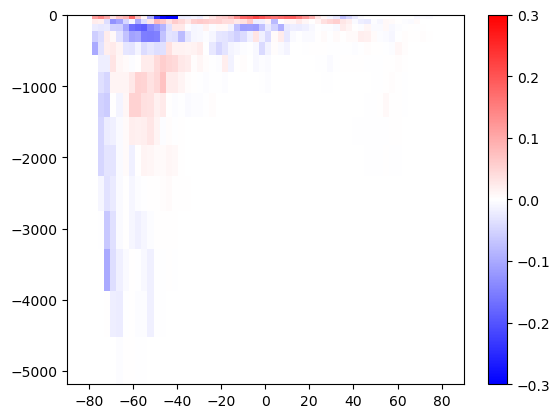

In [53]:
norm = mcolors.CenteredNorm()
var = 'c_dif_v'
sec = np.array(maps_ds[var+source])
sec[sec==0] = np.nan
sec = np.nanmean(sec,axis = -1)
plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',vmax = 0.3,vmin = -0.3)
plt.colorbar()

/tmp/ipykernel_1492850/918103040.py:5: RuntimeWarning: Mean of empty slice
  sec = np.nanmean(sec,axis = -1)


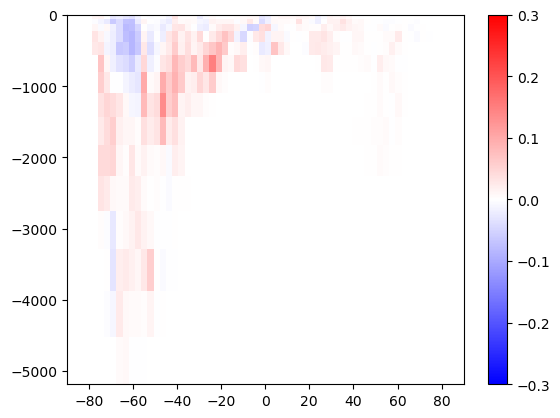

In [54]:
norm = mcolors.CenteredNorm()
var = 'c_dif_h'
sec = np.array(maps_ds[var+source])
sec[sec==0] = np.nan
sec = np.nanmean(sec,axis = -1)
plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',vmax = 0.3,vmin = -0.3)
plt.colorbar()

/tmp/ipykernel_1492850/1112610323.py:5: RuntimeWarning: Mean of empty slice
  sec = np.nanmean(sec,axis = -1)


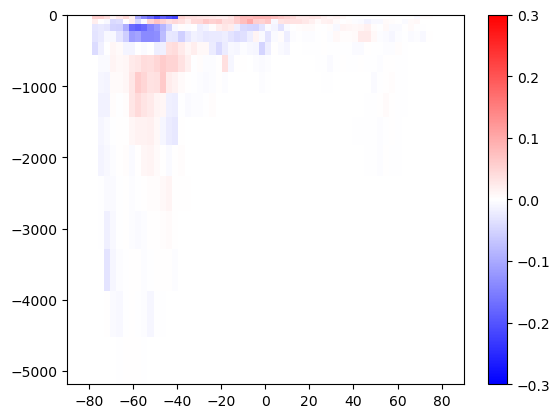

In [55]:
norm = mcolors.CenteredNorm()
var = 'p_dif_v'
sec = np.array(maps_ds[var+source]*116)
sec[sec==0] = np.nan
sec = np.nanmean(sec,axis = -1)
plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',vmax = 0.3,vmin = -0.3)
plt.colorbar()

/tmp/ipykernel_1492850/1656954573.py:5: RuntimeWarning: Mean of empty slice
  sec = np.nanmean(sec,axis = -1)


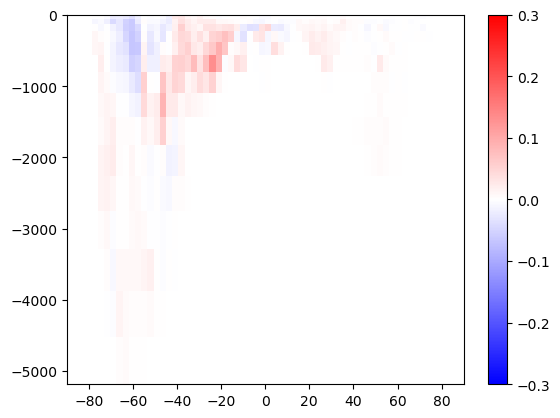

In [56]:
norm = mcolors.CenteredNorm()
var = 'p_dif_h'
sec = np.array(maps_ds[var+source]*116)
sec[sec==0] = np.nan
sec = np.nanmean(sec,axis = -1)
plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',vmax = 0.3,vmin = -0.3)
plt.colorbar()

In [57]:
# var = 'total_bio'
# norm = mcolors.CenteredNorm()
# sec = np.array(ds[var][0])
# sec[sec==0] = np.nan
# sec = np.nanmean(sec,axis = -1)
# plt.pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',norm = norm)
# plt.colorbar()

In [58]:
var = 'c_dif_v'
def plot_mer(var):
    norm = mcolors.CenteredNorm()
    fig,axs = plt.subplots(1,3,sharey = True)
    sec = np.array(maps_ds[var+'_low']+maps_ds[var+'_high'])
    sec[sec==0] = np.nan
    sec = np.nanmean(sec,axis = -1)
    ct = axs[2].pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',norm = norm)
    plt.colorbar(ct,orientation = 'horizontal')
    for i,source in enumerate(['_low','_high']):
        sec = np.array(maps_ds[var+source])
        sec[sec==0] = np.nan
        sec = np.nanmean(sec,axis = -1)
        ct = axs[i].pcolormesh(ds.Y,ds.Z,sec,cmap = 'bwr',norm = norm)
        plt.colorbar(ct,orientation = 'horizontal')

KeyError: 'total_bio_low'

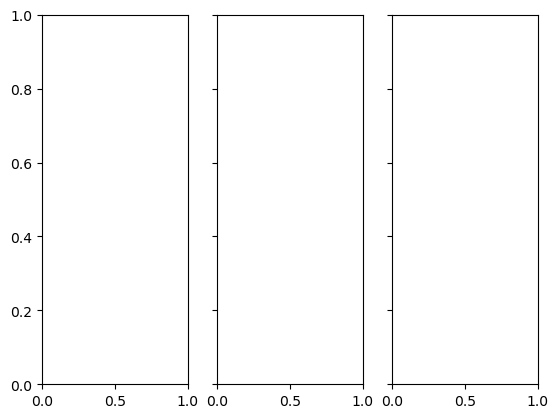

In [59]:
plot_mer('total_bio')

In [ ]:
plot_mer('c_dif_h')

In [ ]:
plot_mer('p_dif_h')

In [ ]:
plot_mer('p_dif_v')

In [ ]:
plt.imshow(hovmoller['cf'])
plt.colorbar()

In [ ]:
plt.imshow(hovmoller['cl'])

In [ ]:
# np.unravel_index(np.abs(hovmoller['total_bio']).argmax(),hovmoller['total_bio'].shape)

In [ ]:
# np.unravel_index(np.abs(hovmoller['forc_c']).argmax(),hovmoller['total_bio'].shape)

In [ ]:
# # for it,(dataset_date, particle_date) in enumerate(zip(to_isel,date_identifier)):
# it = 2812
# dataset_date = to_isel[it]
# particle_date = date_identifier[it]
# my = ds.isel(time = dataset_date)
# prefix ='c'
# termlist = ctermlist
# rhs_list = crhs_list

# prefetch_term = sdlb.prefetch_scalar(my, termlist)
# wall_array = sdlb.prefetch_vector(my,
#                                   xname=prefix+"wallx", yname=prefix+"wally", zname=prefix+"wallz",
#                                   same_size = False
#                                  )
# neo = xr.open_zarr(zarr_fils[it])
# assert particle_date in zarr_fils[it]

# ind = tuple(np.array(i) for i in [neo.iz-1,neo.iy,neo.ix])
# ind1 = tuple(neo['ind1'].values)
# ind2 = tuple(neo['ind2'].values)
# frac = np.array(neo.frac)
# shapes = np.array(neo.shapes)
# tres = np.array(neo.tres)
# tact = np.array(neo.tt)

# step_dic = sdlb.read_prefetched_scalar(ind,termlist,prefetch_term)
# first, last = sdlb.first_last_neither(shapes,return_neither = False)
# s1 = wall_array[ind1]
# s2 = wall_array[ind2]

# s_wall = s1*frac + (1-frac)*s2
# nstep = len(frac)-1
# deltas = np.nan_to_num(np.diff(s_wall))
# deltas[last[:-1]] = 0
# tres_used = -tres[1:]
# tres_used[last[:-1]] = 0 

# correction = sdlb.lhs_contribution(tact, step_dic, last,lhs_name = 'tend_'+prefix)
# rhs_contr = deltas - correction

# contr_dic = sdlb.contr_p_relaxed(rhs_contr, tres_used, step_dic, rhs_list)#,error_prefix = prefix)
# contr_dic[prefix+'lhs'] = correction

# # for var in rhs_list+[prefix+'lhs']:#,prefix+'error']:
# #     cumsum = np.cumsum(np.nan_to_num(contr_dic[var]))
# #     cumsum = np.insert(cumsum[last-1],0,0)
# #     hovmoller[var][it,:] = np.diff(cumsum)

# # hovmoller[prefix+'l'][it,:] = s_wall[last]
# # hovmoller[prefix+'f'][it,:] = s_wall[first]
# # for var in rhs_list:#+[prefix+'error']:
# #     maps[var] += cumu_map_zarr(neo, contr_dic, var, last)
# # maps['count'] += cumu_map_array(neo, np.ones_like(tres_used))
# # hovmoller['lon'][it,:] = np.array(neo.xx[first])
# # hovmoller['lat'][it,:] = np.array(neo.yy[first])
# # hovmoller['dep'][it,:] = np.array(neo.zz[first])

In [ ]:
# var = 'forc_c'

In [ ]:
# np.where(s1==0),np.where(s2==0)

In [ ]:
# ans,(u_list,c_list,lc,ec) = sdlb.check_particle_data_compat(example,xrslc,tp,wall_names=('cwallx','cwally','cwallz'),conv_name = 'c_res_adv',debug  =True)

# ans

# (np.isclose(lc,ec)).sum()/len(lc)

# # (lc)[~np.isclose(lc,ec)]

# (lc)[~np.isclose(lc,ec)]

# np.where(~np.isclose(lc,ec))

# fprefetch = [np.array(xrslc[i].fillna(0)) for i in ['utrans','vtrans','wtrans']]

# cprefetch = [np.array(xrslc[i]) for i in ['cwallx','cwally','cwallz']]

# trans_list = sdlb.read_wall_list(example,tp,fprefetch)

# ip = 21193
# tuple(i[ip] for i in ind)



# cd = sdlb.crude_convergence(trans_list)

# cd[ip],trans_list[:,ip]

# conc_list = sdlb.read_wall_list(example,tp,cprefetch)

# nu_list = trans_list/vol

# # trans_list*s_list

# np.allclose(conc_list,c_list)

# sdlb.crude_convergence(trans_list)

# np.allclose(nu_list,u_list)

# best = sdlb.crude_convergence(trans_list*conc_list/vol)

# np.allclose(ec,best)

# ec

# plt.hist(np.isclose(lc,ec).astype(float))

# where = np.where(~np.isclose(lc,ec))


# where

# # plt.plot(example.yy[where],example.zz[where])

# hfac[~np.isclose(lc,ec)]

# len(lc),len(hfac)

# Np,len(zarr_fils)